# Atuomatically Optimize Prompts + Few Shot Examples for Classification

In [10]:
import pandas as pd
!pip install 'adalflow[openai]' torch datasets matplotlib --quiet

In [11]:
df = pd.read_csv("train.csv")

In [12]:
df

,class_name,question,id
0,3,I've been to this place plenty of times before...,347680
1,4,Them ribs make my mouth water!,380688
2,1,Expensive gimmick. Missleading website. Wide...,356065
3,4,I was looking for last minute hotels and stumb...,133615
4,2,We went to Dixie's Tavern before the Bobcats A...,6645
...,...,...,...
245,2,Walked in on a Friday night and waited for som...,609606
246,4,Worth it just for the view.\n\nWe only went up...,264892
247,1,My first visit to Cadillac Ranch Las Vegas loc...,385265
248,4,After much research into finding a good buffet...,492297


In [13]:
# Jinja2 template of our prompt for optimizing the system prompt
# + adding few shot examples to increase the performance of the model
template = r"""<START_OF_SYSTEM_MESSAGE>
 {{system_prompt}}
 {% if output_format_str is not none %}
 {{output_format_str}}
 {% endif %}
 {% if few_shot_demos is not none %}
 Here are some examples:
 {{few_shot_demos}}
 {% endif %}
 <END_OF_SYSTEM_MESSAGE>
 <START_OF_USER_MESSAGE>
 {{input_str}}
 <END_OF_USER_MESSAGE>
 """

task_desc_template = """You are a review classifier. Given a review, you need to assign it a number of stars. 1 is the lowest rating, and 5 is the highest rating. Assign the review to the correct number of stars. The amount of stars you can pick from is:\n - 1\n - 2\n - 3\n - 4\n - 5\n\n
Do not try to answer the question."""

from adalflow.datasets.types import BaseData
from dataclasses import dataclass, field

@dataclass
class ClassificationDataClass(BaseData):
    question: str = field(
        metadata={"desc": "The question to be classified"},
        default=None,
    )
    class_name: str = field(
        metadata={"desc": "The name of the class to which the question belongs"},
        default=None,
    )
    rationale: str = field(
         metadata={
             "desc": "Your step-by-step reasoning to classify the question to class_name"
         },
         default=None,
     )
    __input_fields__ = ["question"]
    __output_fields__ = ["rationale", "class_name"] # it is important to have the rationale before the class_name


# convert each record to a ClassificationDataClass object, and end up with a list of ClassificationDataClass objects
df_train = pd.read_csv("train.csv")
train_dataset = [ClassificationDataClass( **record ) for record in df_train.to_dict(orient="records")]
val_dataset = [ClassificationDataClass( **record ) for record in pd.read_csv("val.csv").to_dict(orient="records")]
test_dataset = [ClassificationDataClass( **record ) for record in pd.read_csv("test.csv").to_dict(orient="records")]

CLASSES = df_train["class_name"].value_counts()
CLASSES

class_name
1    53
3    52
5    52
2    48
4    45
Name: count, dtype: int64

We define an adaflow component to call the llm and request to classify a question.

In [14]:
from typing import List, Dict, Optional, Union, Tuple, Callable, Any
import adalflow as adal


class ClassificationStructuredOutput(adal.Component):
    
     def __init__(self, classes: List[str], data_class: ClassificationDataClass, model_client: adal.ModelClient, model_kwargs: Dict):
         super().__init__()
         
         task_desc_str = adal.Prompt(
             template=task_desc_template, prompt_kwargs={"classes":  [
             {"label": label}
             for label in classes
         ]}
         )()

         self.data_class = data_class
         self.data_class.set_task_desc(task_desc_str)

         self.parser = adal.DataClassParser(
             data_class=self.data_class, return_data_class=True, format_type="yaml"
         )

         prompt_kwargs = {
             "system_prompt": adal.Parameter(
                 data=self.parser.get_task_desc_str(),
                 role_desc="Task description",
                 requires_opt=True,
                 param_type=adal.ParameterType.PROMPT,
             ),
             "output_format_str": adal.Parameter(
                 data=self.parser.get_output_format_str(),
                 role_desc="Output format requirements",
                 requires_opt=False,
                 param_type=adal.ParameterType.PROMPT,
             ),
             "few_shot_demos": adal.Parameter(
                 data=None,
                 requires_opt=True,
                 role_desc="Few shot examples to help the model",
                 param_type=adal.ParameterType.DEMOS,
             ),
         }

         self.llm = adal.Generator(
             model_client=model_client,
             model_kwargs=model_kwargs,
             prompt_kwargs=prompt_kwargs,
             template=template,
             output_processors=self.parser,
             use_cache=True,
         )

     def _prepare_input(self, question: str):
         input_data = self.data_class(question=question)
         input_str = self.parser.get_input_str(input_data)
         prompt_kwargs = {
             "input_str": adal.Parameter(
                 data=input_str, requires_opt=False, role_desc="input to the LLM"
             )
         }
         return prompt_kwargs

     def call(
         self, question: str, id: Optional[str] = None
     ) -> Union[adal.GeneratorOutput, adal.Parameter]:
         prompt_kwargs = self._prepare_input(question)
         output = self.llm(prompt_kwargs=prompt_kwargs, id=id)
         return output

We define a component that will be used to train the model. This component will use the ClassificationStructuredOutput component to classify the questions.

In [15]:
from adalflow.eval.answer_match_acc import AnswerMatchAcc

class ClassificationComponent(adal.AdalComponent):
    def __init__(
        self,
        classification_structured_output: ClassificationStructuredOutput,
        teacher_model_config: Dict,
        backward_engine_model_config: Dict,
        text_optimizer_model_config: Dict,
    ):
        task = classification_structured_output
        # We use the exact match accuracy as the evaluation metric, it's either 1 or 0.
        eval_fn = AnswerMatchAcc(type="exact_match").compute_single_item
        # Returns a float in range [0, 1], and the higher the better.
        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=eval_fn,
            eval_fn_desc="exact_match: 1 if str(y) == str(y_gt) else 0",
        )
        super().__init__(
            task=task,
            eval_fn=eval_fn,
            loss_fn=loss_fn,
            backward_engine_model_config=backward_engine_model_config,
            text_optimizer_model_config=text_optimizer_model_config,
            teacher_model_config=teacher_model_config,
        )

    def handle_one_task_sample(self, sample: ClassificationDataClass):
        """We return a tuple of the call function and the kwargs to be passed to the call function.
        You can find the implementation of the call function in the ClassificationStructuredOutput class."""
        return self.task.call, {"question": sample.question, "id": sample.id}

    def evaluate_one_sample(
        self, sample: ClassificationDataClass, y_pred: adal.GeneratorOutput
    ) -> float:
        """We evaluate the model's prediction on a single sample. We return a float value as the evaluation metric."""
        y_label = -1
        if y_pred and y_pred.data is not None and y_pred.data.class_name is not None:
            y_label = y_pred.data.class_name
        return self.eval_fn(y_label, sample.class_name)

    def handle_one_loss_sample(
        self, sample: ClassificationDataClass, y_pred: adal.Parameter, *args, **kwargs
    ) -> Tuple[Callable[..., Any], Dict]:
        """We return a tuple of the loss function and the kwargs to be passed to the loss function."""
        full_response = y_pred.full_response
        y_label = -1
        if (
            full_response
            and full_response.data is not None
            and full_response.data.class_name is not None
        ):
            y_label = full_response.data.class_name

        y_pred.eval_input = y_label
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.class_name,
            eval_input=sample.class_name,
            requires_opt=False,
        )
        return self.loss_fn, {"kwargs": {"y": y_pred, "y_gt": y_gt}}

    def configure_teacher_generator(self):
        super().configure_teacher_generator_helper(**self.teacher_model_config)

    def configure_backward_engine(self):
        super().configure_backward_engine_helper(**self.backward_engine_model_config)

    def configure_optimizers(self):
        to = super().configure_text_optimizer_helper(**self.text_optimizer_model_config)
        do = super().configure_demo_optimizer_helper()
        return to + do

In [ ]:
from datasets import Dataset

def train(
    classification_component: ClassificationComponent,
    train_dataset: Dataset,
    test_dataset: Dataset = None,
    val_dataset: Dataset = None,
    train_batch_size=4,  # larger batch size is not that effective, probably because of llm's lost in the middle
    raw_shots: int = 0,
    bootstrap_shots: int = 1,
    max_steps=12,
    num_workers=1,
    strategy="constrained",
    optimization_order="sequential",
    debug=False,
):

    trainer = adal.Trainer(
        train_batch_size=train_batch_size,
        adaltask=classification_component,
        strategy=strategy,
        max_steps=max_steps,
        num_workers=num_workers,
        raw_shots=raw_shots,
        bootstrap_shots=bootstrap_shots,
        debug=debug,
        weighted_sampling=True,
        optimization_order=optimization_order,
        exclude_input_fields_from_bootstrap_demos=True,
    )
    trainer.fit(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        debug=debug,
    )
    return trainer
    
from adalflow.components.model_client.openai_client import OpenAIClient

gpt_4o_mini_model = {
    "model_client": OpenAIClient(input_type="text"),
    "model_kwargs": {
        "model": "gpt-4o-mini",
        "max_tokens": 2000,
        "temperature": 0.0,
        "top_p": 0.99,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "stop": None,
    },
}


gpt_4o_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "gpt-4o",
        "temperature": 1,
        "top_p": 0.99,
        "max_tokens": 1000,
        # "frequency_penalty": 1,  # high for nto repeating prompt
    },
}

# Config for generating the classification
classification_structured_output = ClassificationStructuredOutput(
    **gpt_4o_mini_model,
    classes=CLASSES,
    data_class=ClassificationDataClass,
)
    
# Config for the training configuration
classification_component = ClassificationComponent(
    classification_structured_output=classification_structured_output,
    text_optimizer_model_config=gpt_4o_model,
    backward_engine_model_config=gpt_4o_model,
    teacher_model_config=gpt_4o_model,
)


train_object = train(
    classification_component=classification_component,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    debug=False,
    max_steps=12,
    strategy="constrained",
    optimization_order="sequential"
)


In [17]:
import json
ckpt_file = json.load(open(train_object.ckpt_file))
test_scores = ckpt_file["test_scores"]

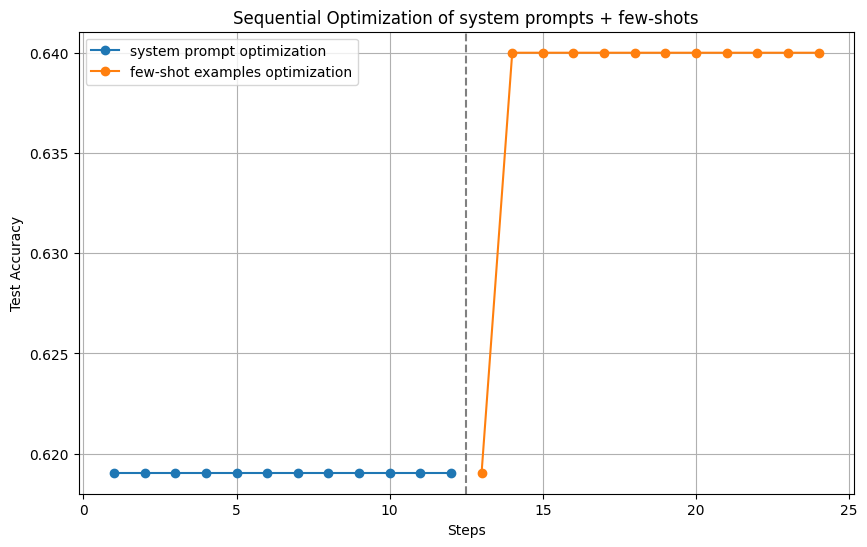

In [19]:
import matplotlib.pyplot as plt

methods = ["system prompt optimization"] * 12 + [
    "few-shot examples optimization"
] * 12
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, 13),
    test_scores[:12],
    marker="o",
    label="system prompt optimization",
)
plt.plot(
    range(13, 25),
    test_scores[12:24],
    marker="o",
    label="few-shot examples optimization",
)

plt.axvline(x=12.5, color="gray", linestyle="--")  # Divider between methods

plt.xlabel("Steps")
plt.ylabel("Test Accuracy")
plt.title("Sequential Optimization of system prompts + few-shots")
plt.legend()
plt.grid(True)

plt.show()